In [30]:
# https://carpentries-incubator.github.io/geospatial-python/aio/index.html
from pystac_client import Client
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import rioxarray
import numpy as np
import xarray as xr
bbox={'lonLower':llon,'latLower':llat,'lonHigher':rlon,'latHigher':ulat}
# https://carpentries-incubator.github.io/geospatial-python/aio/index.html
# https://data.chs-shc.ca/dashboard/map
# https://stacindex.org/catalogs/earth-search#/Cnz1sryATwWudkxyZekxWx6356v9RmvvCcLLw79uHWJUDvt2?t=2
# catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
catalog = Client.open('https://earth-search.aws.element84.com/v0')
# catalog1 = Client.open('https://earthengine-stac.storage.googleapis.com/catalog/COPERNICUS')
mysearch = catalog.search(collections=['sentinel-s2-l2a-cogs'],
                          bbox=[bbox['lonLower'],bbox['latLower'],bbox['lonHigher'],bbox['latHigher']],
                        #   query =  {"eo:cloud_cover":{"lt":1}},
                          datetime='2019-01-01/2019-02-01', 
                          max_items=10)   

resdict = mysearch.get_all_items()

In [44]:
resdict[0].id.split('_')[2]

'20190129'

In [5]:
print(resdict[0])
b02 = rioxarray.open_rasterio(resdict[0].assets['B02'].href)
b03 = rioxarray.open_rasterio(resdict[0].assets['B03'].href)
b04 = rioxarray.open_rasterio(resdict[0].assets['B04'].href)
b08 = rioxarray.open_rasterio(resdict[0].assets['B08'].href)
b11 = rioxarray.open_rasterio(resdict[0].assets['B11'].href)
b12 = rioxarray.open_rasterio(resdict[0].assets['B12'].href)
overview = rioxarray.open_rasterio(resdict[0].assets['overview'].href) #low res image for shape
#use 'visual' asset for true colour image

In [6]:
b11 = b11.rio.reproject_match(b02)
b12 = b12.rio.reproject_match(b02)

In [3]:
# !gdalinfo /Users/gclyne/Downloads/products/GeoTIFF/NONNA10_4440N06430W.tiff
# https://gis.stackexchange.com/questions/57834/how-to-get-raster-corner-coordinates-using-python-gdal-bindings

from osgeo import gdal 
src = gdal.Open('/Users/gclyne/Downloads/1045100064200_201901_RAW_DEM/1045100064200_201901_RAW_DEM.tif')
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
lrx = ulx + (src.RasterXSize * xres)
lry = uly + (src.RasterYSize * yres)

from osgeo import ogr
from osgeo import osr

# Setup the source projection - you can also import from epsg, proj4...
source = osr.SpatialReference()
source.ImportFromWkt(src.GetProjection())

# The target projection
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

# Create the transform - this can be used repeatedly
transform = osr.CoordinateTransformation(source, target)

# Transform the point. You can also create an ogr geometry and use the more generic `point.Transform()`
ulat,llon,_ = transform.TransformPoint(ulx, uly)
llat,rlon,_ = transform.TransformPoint(lrx,lry)





<AxesSubplot: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

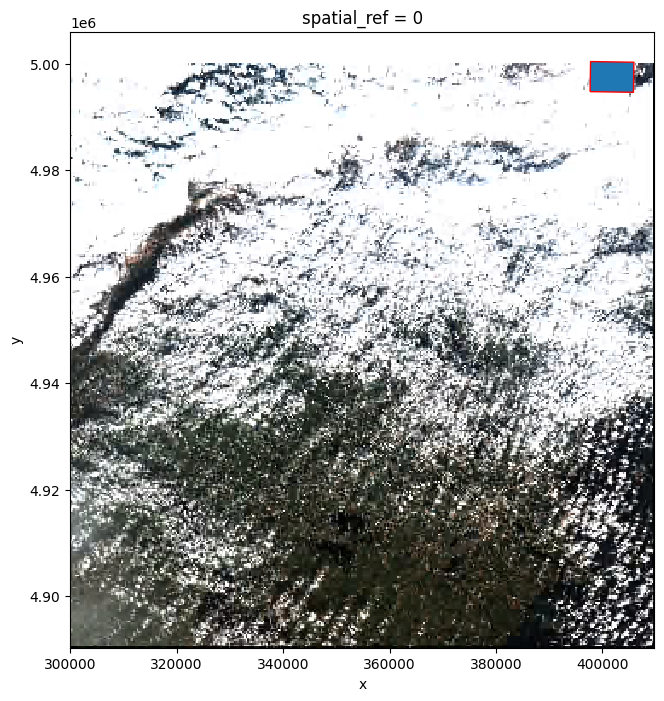

In [52]:

# Plot
fig, ax = plt.subplots()
fig.set_size_inches((8,8))

# Plot image
overview.plot.imshow(ax=ax)

# Plot crop fields
projected_poly.plot(
    ax=ax,
    edgecolor="red",
)

In [7]:
poly = Polygon([[llon,llat],[rlon,llat],[rlon,ulat],[llon,ulat]])

projected_poly = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[poly])
projected_poly = projected_poly.to_crs(b02.rio.crs)

bathy = rioxarray.open_rasterio('/Users/gclyne/Downloads/1045100064200_201901_RAW_DEM/1045100064200_201901_RAW_DEM.tif')
def process_band(band:xr.DataArray):
    band = band.rio.clip_box(*projected_poly.total_bounds)
    band = band.rio.reproject_match(bathy)
    band = band.rio.interpolate_na()
    return band


b02 = process_band(b02)
b03 = process_band(b03)
b04 = process_band(b04)
b08 = process_band(b08)
b11 = process_band(b11)
b12 = process_band(b12)







In [8]:
sat_s2 = np.concatenate((b02,b03,b04,b08,b11,b12),axis=0)


In [15]:
subset = sat_s2[:,0:1000,0:1000]
np.save('test',subset,allow_pickle=True)


In [89]:
import csv
def splitImageArray(array,bound):
    text_file = open("./data/fimg_list.txt", "w")
    for i in range(1001,bound,1001):
        subset = array[:,i:i+1001,i:i+1001]
        name = 'img_' + resdict[0].id.split('_')[2] + '_' + str(i)
        np.save('./data/' + name,subset,allow_pickle=True)
        text_file.write('./data/' + name + '.npy\n')
    text_file.close()

def splitDepthArray(array,bound):
    text_file = open("./data/fdepth_list.txt", "w")
    for i in range(1001,bound,1001):
        subset = array[:,i:i+1001,i:i+1001]
        name = 'depth_' + resdict[0].id.split('_')[2] + '_' + str(i)
        np.save('./data/' + name,subset,allow_pickle=True)
        text_file.write('./data/' + name + '.npy\n')
    text_file.close()    

In [90]:
splitImageArray(sat_s2,max(sat_s2.shape))
splitDepthArray(bathy,max(bathy.shape))

In [24]:
ds_masked = bathy.where(bathy != -99999.) 
np.save('depth',ds_masked.values[:,0:1000,0:1000],allow_pickle=True)


In [23]:
# np.nonzero(depth_stack!=depth_nodata)[0]
bathy.rio.nodata

-99999.0

In [19]:
def split_image(array):
    
ds_masked.values[0,0:1000,0:1000].shape

(1000, 1000)

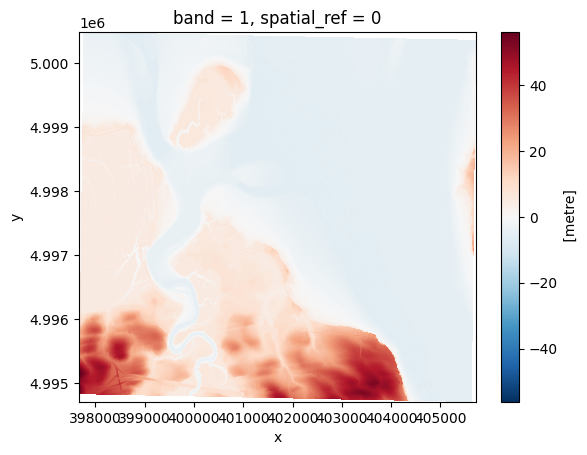

In [13]:
ds_masked.isel(band=0).plot.imshow()

In [28]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    _,r, h = array.shape
    return (array.reshape(h//nrows, nrows, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

# split(ds_masked,1000,1000)
print(ds_masked.values[0].shape)
np.vsplit(ds_masked.values,5777//5)

(5777, 8052)


ValueError: array split does not result in an equal division